In [1]:
import torch
from datasets import load_dataset
from IPython.display import display, Image, update_display, HTML
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
device = "cuda"
class Args:
    def __init__(self):
        self.batch_size = 8
        self.grad_accum_steps = 8
        self.plot_update = 32
        self.min_lr = 1e-7
        self.max_lr = 2e-5
        self.warmup_steps = 2000
        self.weight_decay = 0.
        self.epochs = 10
        self.channels=3
        self.num_workers=12
        self.λ = 0.01
        self.patience = 128
args = Args()

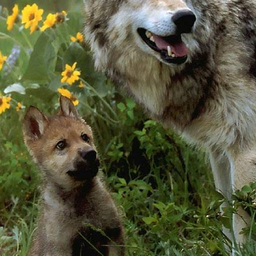

In [3]:
train_dataset = load_dataset("danjacobellis/imagenet_hq", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=1,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [4]:
import torch
import torch.nn as nn
from pytorch_wavelets import DTCWTForward, DTCWTInverse
import diffusers.models.autoencoders as autoencoders 
class Walloc(nn.Module):
    def __init__(self, channels=3, J=4, latent_dim=[12,36,72,144,288]):
        super().__init__()
        self.wavelet_analysis  = DTCWTForward(J=J, biort='near_sym_b', qshift='qshift_b')
        self.L_encode = nn.Sequential(
            autoencoders.autoencoder_kl.Encoder(
                in_channels = channels,
                out_channels = latent_dim[0],
                down_block_types = 2*('DownEncoderBlock2D',),
                block_out_channels = 2*(latent_dim[0],),
                layers_per_block = 2,
                norm_num_groups = 4,
                act_fn = 'silu',
                double_z = False,
                mid_block_add_attention=True,
            ),
            torch.nn.Hardtanh(min_val=-7.499, max_val=7.499),
        )
        self.wavelet_synthesis = DTCWTInverse(biort='near_sym_b', qshift='qshift_b')
        self.L_decode = nn.Sequential(
            autoencoders.autoencoder_kl.Decoder(
                in_channels = latent_dim[0],
                out_channels = channels,
                up_block_types = 2*('UpDecoderBlock2D',),
                block_out_channels = 2*(latent_dim[0],),
                layers_per_block = 2,
                norm_num_groups = 4,
                act_fn = 'silu',
                mid_block_add_attention=True,
            ),
            torch.nn.Hardtanh(min_val=-0.5, max_val=0.5),
        )
    def forward(self, x):
        L, H = self.wavelet_analysis(x)
        z_L = self.L_encode(L)
        L_hat = self.L_decode(z_L)
        x_hat = self.wavelet_synthesis((L_hat, H))
        return x_hat

In [5]:
codec = Walloc().to(device)

In [6]:
with torch.no_grad():
    x = valid_batch.clone()
    L, H = codec.wavelet_analysis(x)
    z_L = codec.L_encode(L)
    L_hat = codec.L_decode(z_L)
    x_hat = codec.wavelet_synthesis((L_hat, H))

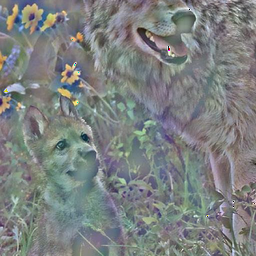

In [7]:
for img in x_hat:
    display(ToPILImage()(img+0.5))